In [6]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import glob
import cv2
import os
import locale
import seaborn as sns
from datetime import timedelta, datetime
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import plotly.graph_objects as go


In [7]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from kerastuner.tuners import RandomSearch
import kerastuner as kt

In [9]:
df=pd.read_csv(r"Data.csv")


In [10]:
df

,Gas,Rock,TOC (%),Moisture (%),Temp (C),Pres. (MPa),C1 Excess Sorption (cm3/gr),CO2 Excess Sorption (cm3/gr)
0,0,Shale,1.66,1.42,50,0.4413,0.0468,0
1,0,Shale,1.66,1.42,50,0.9308,0.0842,0
2,0,Shale,1.66,1.42,50,1.4617,0.1186,0
3,0,Shale,1.66,1.42,50,2.8337,0.2246,0
4,0,Shale,1.66,1.42,50,5.7158,0.3682,0
...,...,...,...,...,...,...,...,...
1195,0,Shale,4.76,1.50,70,2.2100,1.4600,0
1196,0,Shale,4.76,1.50,70,4.2800,1.9500,0
1197,0,Shale,4.76,1.50,70,6.2100,2.1700,0
1198,0,Shale,4.76,1.50,70,8.6700,2.2600,0


In [11]:
df.head()

,Gas,Rock,TOC (%),Moisture (%),Temp (C),Pres. (MPa),C1 Excess Sorption (cm3/gr),CO2 Excess Sorption (cm3/gr)
0,0,Shale,1.66,1.42,50,0.4413,0.0468,0
1,0,Shale,1.66,1.42,50,0.9308,0.0842,0
2,0,Shale,1.66,1.42,50,1.4617,0.1186,0
3,0,Shale,1.66,1.42,50,2.8337,0.2246,0
4,0,Shale,1.66,1.42,50,5.7158,0.3682,0


In [12]:
df.shape

(1200, 8)

In [13]:
import matplotlib.pyplot as plt

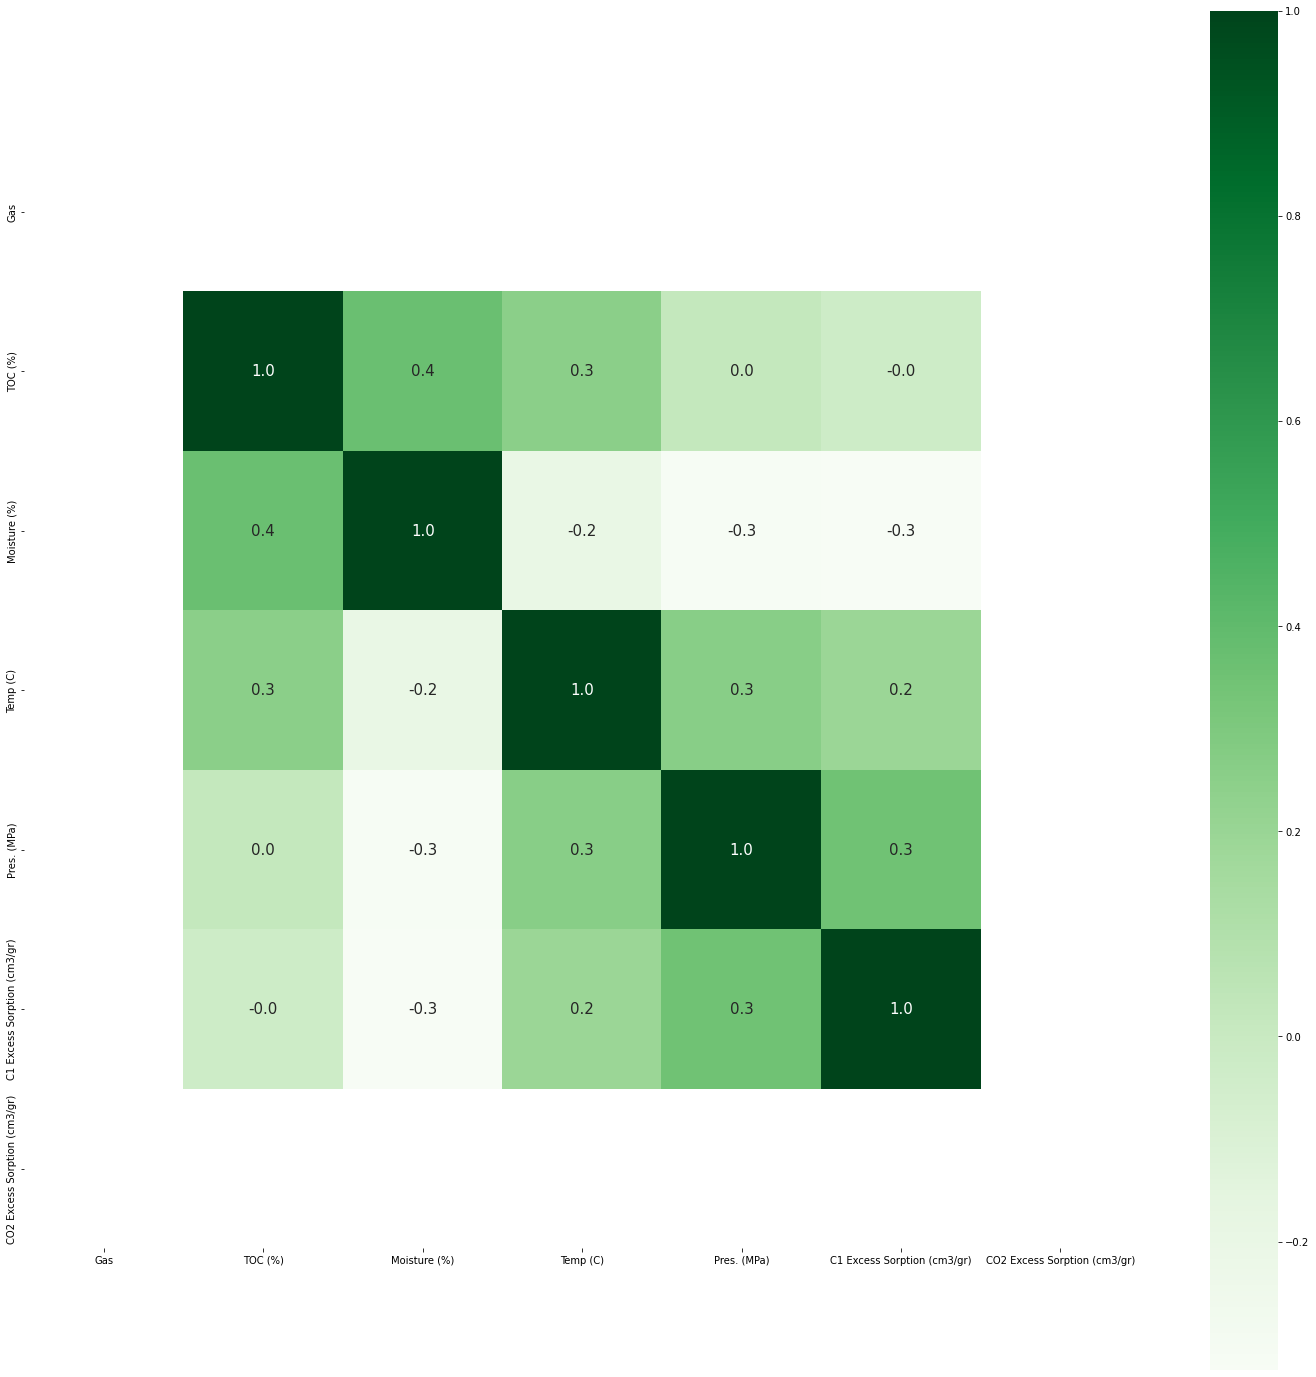

In [14]:
corr=df.corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr , cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Greens')

In [15]:
df.columns

Index(['Gas', 'Rock', 'TOC (%)', 'Moisture (%)', 'Temp (C)', 'Pres. (MPa)',
       'C1 Excess Sorption (cm3/gr)', 'CO2 Excess Sorption (cm3/gr)'],
      dtype='object')

In [16]:
df.dtypes

Gas                               int64
Rock                             object
TOC (%)                         float64
Moisture (%)                    float64
Temp (C)                          int64
Pres. (MPa)                     float64
C1 Excess Sorption (cm3/gr)     float64
CO2 Excess Sorption (cm3/gr)      int64
dtype: object

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gas                           1200 non-null   int64  
 1   Rock                          1200 non-null   object 
 2   TOC (%)                       1200 non-null   float64
 3   Moisture (%)                  1200 non-null   float64
 4   Temp (C)                      1200 non-null   int64  
 5   Pres. (MPa)                   1200 non-null   float64
 6   C1 Excess Sorption (cm3/gr)   1200 non-null   float64
 7   CO2 Excess Sorption (cm3/gr)  1200 non-null   int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 75.1+ KB


In [18]:
df.describe()

,Gas,TOC (%),Moisture (%),Temp (C),Pres. (MPa),C1 Excess Sorption (cm3/gr),CO2 Excess Sorption (cm3/gr)
count,1200.0,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.0
mean,0.0,11.946637,2.495300,48.523333,9.969668,1.260853,0.0
std,0.0,21.084400,2.050286,19.675333,7.214140,1.260792,0.0
min,0.0,0.090000,0.200000,30.000000,0.164000,0.001600,0.0
25%,0.0,1.700000,0.680000,30.000000,5.233850,0.300000,0.0
50%,0.0,5.150000,1.660000,45.000000,7.018250,0.695720,0.0
75%,0.0,10.940000,4.000000,60.000000,14.900250,1.720940,0.0
max,0.0,88.500000,10.970000,130.000000,27.861700,5.360000,0.0


In [19]:
y=df['C1 Excess Sorption (cm3/gr)']

In [20]:
y

0       0.0468
1       0.0842
2       0.1186
3       0.2246
4       0.3682
         ...  
1195    1.4600
1196    1.9500
1197    2.1700
1198    2.2600
1199    2.3000
Name: C1 Excess Sorption (cm3/gr), Length: 1200, dtype: float64

In [21]:
X = df[['TOC (%)','Temp (C)','Moisture (%)','Pres. (MPa)',]].values

In [22]:
X

array([[ 1.66  , 50.    ,  1.42  ,  0.4413],
       [ 1.66  , 50.    ,  1.42  ,  0.9308],
       [ 1.66  , 50.    ,  1.42  ,  1.4617],
       ...,
       [ 4.76  , 70.    ,  1.5   ,  6.21  ],
       [ 4.76  , 70.    ,  1.5   ,  8.67  ],
       [ 4.76  , 70.    ,  1.5   , 10.94  ]])

In [23]:
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.20,random_state=26)

In [24]:
X_test

array([[ 62.2       ,  61.        ,   6.4       ,   7.91      ],
       [  3.98      ,  45.        ,   0.25      ,  18.012     ],
       [ 10.94      ,  70.        ,   2.65      ,  13.84997887],
       [  0.45      ,  80.        ,   0.61      ,   1.4962    ],
       [  3.46      ,  30.        ,   5.51      ,   6.        ],
       [  1.72      ,  30.        ,   2.62      ,   6.        ],
       [ 10.94      ,  45.        ,   0.39      ,  14.313     ],
       [  5.15      ,  30.        ,   6.94      ,   6.1761    ],
       [  5.79      ,  45.        ,   0.41      ,   5.102     ],
       [  5.41      ,  45.        ,   0.3       ,   3.473     ],
       [  5.41      ,  45.        ,   1.81      ,  20.902     ],
       [ 10.94      , 100.        ,   2.65      ,  15.38228783],
       [  5.7       ,  38.        ,   2.8       ,  21.7095    ],
       [  1.91      ,  30.        ,   3.63      ,   6.        ],
       [ 10.94      , 130.        ,   2.65      ,  15.5253222 ],
       [  1.81      ,  30

In [25]:
X_train

array([[  4.76      ,  60.        ,   1.5       ,   8.67      ],
       [ 10.94      ,  45.        ,   0.39      ,   4.205     ],
       [  1.51      ,  45.        ,   0.74      ,   5.448     ],
       ...,
       [  6.11      ,  64.        ,   1.5       ,  20.22      ],
       [  4.05      ,  57.        ,   1.5       ,   9.57      ],
       [ 10.94      , 130.        ,   2.65      ,  19.01113305]])

In [26]:
y_train

1191    2.590000
692     3.051496
513     0.152777
489     1.329100
580     0.461797
          ...   
941     3.991722
160     0.265200
1101    4.780000
1126    2.950000
821     2.304704
Name: C1 Excess Sorption (cm3/gr), Length: 960, dtype: float64

In [27]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train[:, :] = sc.fit_transform(X_train[:, :])
X_test[:, :] = sc.transform(X_test[:, :])

In [28]:
X_train

array([[0.05282208, 0.3       , 0.12070566, 0.30710131],
       [0.12272367, 0.15      , 0.0176416 , 0.14589659],
       [0.01606153, 0.15      , 0.05013928, 0.19077396],
       ...,
       [0.06809184, 0.34      , 0.12070566, 0.72410345],
       [0.04479131, 0.27      , 0.12070566, 0.33959498],
       [0.12272367, 1.        , 0.22748375, 0.68045842]])

In [29]:
print(X_train.shape)
print(X_test.shape)

(960, 4)
(240, 4)


In [30]:
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import tensorflow as tf
import kerastuner as kt
msle = MeanSquaredLogarithmicError()
def build_model(hp):
  model = tf.keras.Sequential()
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units1', min_value=8, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=8, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=8, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
      loss=msle,
      metrics=[msle] )
  return model

tuner = kt.Hyperband(
    build_model,
    objective='val_mean_squared_logarithmic_error',
    max_epochs=10,
    directory='keras_tuner_dir',
    project_name='keras_tuner_demo')
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

Trial 30 Complete [00h 00m 02s]
val_mean_squared_logarithmic_error: 0.0809108093380928

Best val_mean_squared_logarithmic_error So Far: 0.049130309373140335
Total elapsed time: 00h 00m 55s
INFO:tensorflow:Oracle triggered exit


In [31]:
from kerastuner import HyperModel


class ANNHyperModel(HyperModel):
    
    def build(self, hp):
      model = tf.keras.Sequential()
      # Tune the number of units in the first Dense layer
      # Choose an optimal value between 32-512
      hp_units1 = hp.Int('units1', min_value=8, max_value=512, step=32)
      hp_units2 = hp.Int('units2', min_value=8, max_value=512, step=32)
      hp_units3 = hp.Int('units3', min_value=8, max_value=512, step=32)
      model.add(Dense(units=hp_units1, activation='relu'))
      model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
      model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))
      model.add(Dense(1, kernel_initializer='normal', activation='linear'))

      # Tune the learning rate for the optimizer
      # Choose an optimal value from 0.01, 0.001, or 0.0001
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

      model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
          loss=msle,
          metrics=[msle]
      )

      return model

hypermodel = ANNHyperModel()

tuner = kt.Hyperband(
    hypermodel,
    objective='val_mean_squared_logarithmic_error',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_dir',
    project_name='keras_tuner_demo2'
)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

Trial 30 Complete [00h 00m 03s]
val_mean_squared_logarithmic_error: 0.05604426562786102

Best val_mean_squared_logarithmic_error So Far: 0.050553541630506516
Total elapsed time: 00h 00m 51s
INFO:tensorflow:Oracle triggered exit


In [32]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))
 


units1 456
units2 392
units3 360
learning_rate 0.01


In [33]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train.shape)


In [34]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (960, 456)                2280      
                                                                 
 dense_1 (Dense)             (960, 392)                179144    
                                                                 
 dense_2 (Dense)             (960, 360)                141480    
                                                                 
 dense_3 (Dense)             (960, 1)                  361       
                                                                 
Total params: 323,265
Trainable params: 323,265
Non-trainable params: 0
_________________________________________________________________


In [35]:
best_model.fit(
    X_train, 
    y_train,
    epochs=10,
    batch_size=64)

Epoch 1/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0423 - mean_squared_logarithmic_error: 0.0423
Epoch 2/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0360 - mean_squared_logarithmic_error: 0.0360
Epoch 3/10
15/15 [==============================] - 0s 2ms/step - loss: 0.0382 - mean_squared_logarithmic_error: 0.0382
Epoch 4/10
15/15 [==============================] - 0s 2ms/step - loss: 0.0356 - mean_squared_logarithmic_error: 0.0356
Epoch 5/10
15/15 [==============================] - 0s 2ms/step - loss: 0.0388 - mean_squared_logarithmic_error: 0.0388
Epoch 6/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0361 - mean_squared_logarithmic_error: 0.0361
Epoch 7/10
15/15 [==============================] - 0s 2ms/step - loss: 0.0342 - mean_squared_logarithmic_error: 0.0342
Epoch 8/10
15/15 [==============================] - 0s 2ms/step - loss: 0.0336 - mean_squared_logarithmic_error: 0.0336
Epoch 9/10
15/15 [======================

In [36]:
# mean squared logarithmic error
msle(y_test, best_model.predict(X_test)).numpy()



0.45114508

In [37]:
predictions=best_model.predict(X_test)

In [38]:
predictions

array([[0.29365256],
       [0.7413641 ],
       [3.2789953 ],
       [0.04517402],
       [0.61159205],
       [0.37153354],
       [3.8340218 ],
       [0.79308695],
       [1.3689693 ],
       [1.032986  ],
       [1.3036538 ],
       [2.3925836 ],
       [0.8552383 ],
       [0.3380366 ],
       [2.1942487 ],
       [0.34769142],
       [1.5478213 ],
       [0.04167383],
       [4.3866153 ],
       [0.5444072 ],
       [3.55991   ],
       [0.19519627],
       [0.12484397],
       [0.9931913 ],
       [0.8337531 ],
       [0.9021327 ],
       [0.6990643 ],
       [0.5656356 ],
       [0.83345395],
       [1.4389466 ],
       [2.6586823 ],
       [0.22722417],
       [0.2256605 ],
       [2.0163138 ],
       [0.39240754],
       [0.04049563],
       [2.5209436 ],
       [0.75758123],
       [0.04970666],
       [0.23409489],
       [0.7876398 ],
       [0.8412768 ],
       [0.7458648 ],
       [2.0083663 ],
       [0.2496447 ],
       [2.1153636 ],
       [1.3783123 ],
       [0.976

In [39]:
y_test

970    0.238400
568    0.746137
766    3.383213
110    0.040600
350    0.900000
         ...   
936    3.978579
639    1.314027
385    0.430000
761    3.057582
573    0.696059
Name: C1 Excess Sorption (cm3/gr), Length: 240, dtype: float64

In [40]:
from sklearn import metrics

In [41]:
print('Training , Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))  
print('Training , Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))  
print('Training , Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Training , Mean Absolute Error: 0.3179349078129147
Training , Mean Squared Error: 0.4028855678862504
Training , Root Mean Squared Error: 0.6347326743490131


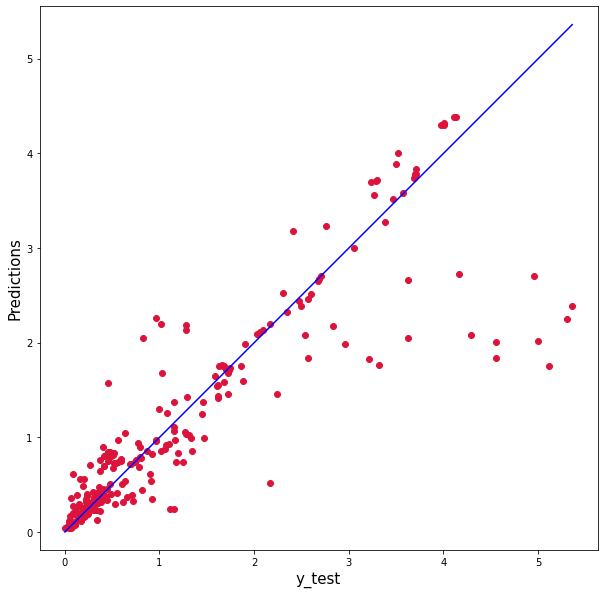

In [42]:
plt.figure(figsize=(10,10))
plt.scatter(y_test,predictions, c='crimson')


p1 = max(max(predictions), max(y_test))
p2 = min(min(predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [44]:
print(metrics.r2_score(y_test, predictions)) 

0.7577063482193159
